In [1]:
# For data manipulation
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [ ]:
# Load the dataset into a DataFrame and save in a variable
df0 = pd.read_csv("datasets/listings.csv")
# Display the first 10 rows of the data
#df0.head(10)
#pd.set_option('display.max_rows',None)
#df0.isna().sum()

In [ ]:
# Cast our data to the appropriate types for the contained values
# convert ('host_since', 'first_review', 'last_review') to datetime
df0['host_since'] = pd.to_datetime(df0['host_since'])
df0['first_review'] = pd.to_datetime(df0['first_review'])
df0['last_review'] = pd.to_datetime(df0['last_review'])
# convert ('price') to numeric
df0['price'] = df0['price'].replace(
    {r'\$': '', ',': ''}, regex=True)
df0['price'] = pd.to_numeric(df0['price'])
#df0.info()

In [ ]:
# Add derived columns to represent our datetime values as "days since" integers assuming the current date is 2025-10-31
df0['days_on_platform'] = (pd.to_datetime('2025-10-31') - df0['host_since']).dt.days
df0['days_since_last_review'] = (pd.to_datetime('2025-10-31') - df0['last_review']).dt.days
df0['days_since_first_review'] = (pd.to_datetime('2025-10-31') - df0['first_review']).dt.days
#df0.info()

In [ ]:
# Add derived categorical column to directly capture whether a listing has previously been reviewed
df0['ever_reviewed'] = df0['number_of_reviews'].notna().astype(int)
# Add categorical columns for our rich text columns
df0['ever_named'] = df0['name'].notna().astype(int)
df0['ever_described'] = df0['description'].notna().astype(int)
df0['ever_neighborhood_overview'] = df0['neighborhood_overview'].notna().astype(int)
df0['ever_amenities'] = df0['amenities'].notna().astype(int)

In [ ]:
# Add descriptive numeric columns for our rich text columns
df0['name_length'] = df0['name'].str.len().fillna(0).astype(int)
df0['description_length'] = df0['description'].str.len().fillna(0).astype(int)
df0['neighborhood_overview_length'] = df0['neighborhood_overview'].str.len().fillna(0).astype(int)
df0['amenities_length'] = df0['amenities'].str.len().fillna(0).astype(int)
#df0.head()

In [ ]:
# For dropping columns if we don't need them for our analysis
df1 = df0.drop(['host_since', 'last_review', 'first_review', 'scrape_id', 'host_location', 'neighbourhood', 'calendar_updated', 'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude', 'listing_url', 'id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'property_type', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_last_scraped', 'host_has_profile_pic', 'host_verifications', 'beds', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'bathrooms_text'], axis=1)
#df1.info()
#df1.head()

In [ ]:
# Drop rows that have missing values in one of these columns
df2 = df1.dropna(axis=0, how='any', subset=['estimated_revenue_l365d', 'price', 'bedrooms', 'bathrooms', 'host_listings_count', 'host_listings_count'], inplace=False, ignore_index=False)
#df2.info()

In [ ]:
# Encode categorical columns using pd.Categorical
# This should automatically convert any NaN values to '-1'

# List of categorical columns to encode
categorical_columns = ['license', 'has_availability', 'host_is_superhost', 'instant_bookable', 'host_identity_verified']

# Apply pd.Categorical to each column using .loc
# Just... stopped working.
#for col in categorical_columns:
#    df2.loc[:, col] = pd.Categorical(df2[col]).codes.astype('int64')

# Switched to using assign to stop dealing with weird .loc behavior
new_cols = {
    col: pd.Categorical(df2[col]).codes.astype('int64')
    for col in categorical_columns
}
df2 = df2.assign(**new_cols)

# Check resulting types for categorical columns
#print(df2[categorical_columns].dtypes)

#df2.info()

In [ ]:
# UNCOMMENT to Replace missing values in these columns with '-1'
# This should support some additional analysis but may not be appropriate for all tasks
# To test *just* the relationship between having ever been reviewed, use the derived 'ever_reviewed' column

#columns_to_replace = ['reviews_per_month', 'days_since_last_review', 'days_since_first_review', 'review_scores_value', 'review_scores_location', 'review_scores_communication', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_rating']
#df2.loc[:, columns_to_replace] = df2[columns_to_replace].fillna(-1)

In [ ]:
#validate the column and value dropping conversion
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20191 entries, 0 to 36110
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          20191 non-null  object 
 1   description                                   19805 non-null  object 
 2   neighborhood_overview                         10144 non-null  object 
 3   host_is_superhost                             20191 non-null  int64  
 4   host_listings_count                           20191 non-null  float64
 5   host_total_listings_count                     20191 non-null  float64
 6   host_identity_verified                        20191 non-null  int64  
 7   neighbourhood_cleansed                        20191 non-null  object 
 8   neighbourhood_group_cleansed                  20191 non-null  object 
 9   room_type                                     20191 non-null  obje

In [ ]:
# define custom function for outlier filtering based on:
# <value> <= 1.5*IQR
# OR
# <value> >= 1.5*IQR
# Results in a mask that needs to be applied
# Intent is for this to be independently calculated against the price values for each neighbourhood
def get_outlier_mask(x, multiplier=1.5):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - multiplier * IQR
    upper_limit = Q3 + multiplier * IQR
    # Return a boolean mask: True for non-outliers, False for outliers
    return (x >= lower_limit) & (x <= upper_limit)

In [ ]:
# Create listings dataframe for just whole apartment/houses from Manhattan or Brooklyn
df_apartment = df2.query("room_type == 'Entire home/apt' and neighbourhood_group_cleansed in ('Manhattan','Brooklyn')")
#df_apartment.info()
#Filter out outliers using previously defined IQR criteria in get_outlier_mask function
mask_apartment = df_apartment.groupby('neighbourhood_cleansed')['price'].transform(get_outlier_mask)
df_apartment_filtered = df_apartment[mask_apartment]

In [ ]:
# Create listings dataframe for just rooms in shared apartment/houses from Manhattan or Brooklyn
df_room = df2.query("room_type == 'Private room' and neighbourhood_group_cleansed in ('Manhattan','Brooklyn')" )
#df_room.info()
#Filter out outliers using previously defined IQR criteria in get_outlier_mask function
mask_room = df_room.groupby('neighbourhood_cleansed')['price'].transform(get_outlier_mask)
df_room_filtered = df_room[mask_room]
#df_room_filtered.info()

Brooklyn          Axes(0.1,0.15;0.363636x0.75)
Manhattan    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

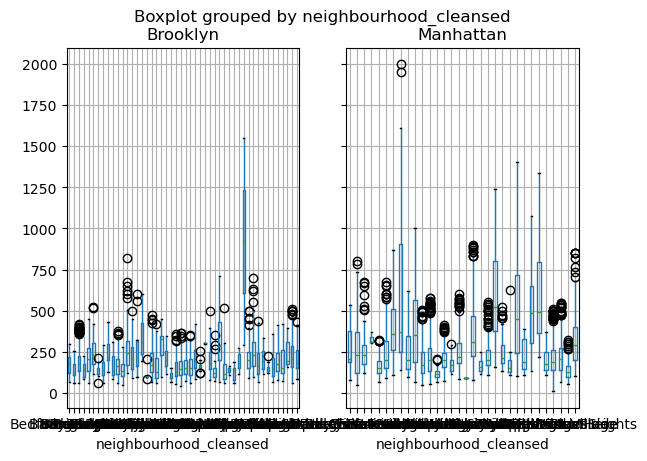

In [ ]:
# Exploratory Data Analysis for each feature
#sns.boxplot(
#    x="neighbourhood_cleansed", y="price", data=df_room_brooklyn_cleaned.query("neighbourhood_cleansed == 'Greenpoint'")
#)
#plt.show()
#df_apartment_brooklyn.boxplot(column='price', by='neighbourhood_cleansed')
#df_room_brooklyn.boxplot(column='price', by='neighbourhood_cleansed')
#df_apartment_manhattan.boxplot(column='price', by='neighbourhood_cleansed')
#df_room_manhattan.boxplot(column='price', by='neighbourhood_cleansed')
#df_room_filtered.groupby("neighbourhood_group_cleansed").boxplot(column='price', by='neighbourhood_cleansed')
df_apartment_filtered.groupby("neighbourhood_group_cleansed").boxplot(column='price', by='neighbourhood_cleansed')


In [ ]:
# Ensure clean DataFrame copies
df_apartment_filtered = df_apartment_filtered.copy()
df_room_filtered = df_room_filtered.copy()

# Add derived columns to apartment df to calculate price per bedroom.
# To cover the case where studio apartments are listed as bedrooms='0.0' we add a new "private_spaces" column that replaces those 0.0 with 1.0
mask = df_apartment_filtered["bedrooms"] == 0.0
df_apartment_filtered.loc[mask, "private_spaces"] = 1.0
df_apartment_filtered.loc[~mask, "private_spaces"] = df_apartment_filtered.loc[~mask, "bedrooms"]
df_apartment_filtered.loc[:, "price_per_private_space"] = (
    df_apartment_filtered["price"] / df_apartment_filtered["private_spaces"]
)

# Add derived column to apartment and room df to calculate price per per person (based on listed "accomodates" value
df_apartment_filtered.loc[:, "price_per_person"] = (
    df_apartment_filtered["price"] / df_apartment_filtered["accommodates"]
)
df_room_filtered.loc[:, "price_per_person"] = (
    df_room_filtered["price"] / df_room_filtered["accommodates"]
)

# Add our north star derived feature: revenue_per_person
# calculated based on estimated revenue and "accomodates" value
df_apartment_filtered.loc[:, "revenue_per_person"] = (
    df_apartment_filtered["estimated_revenue_l365d"] / df_apartment_filtered["accommodates"]
)
df_room_filtered.loc[:, "revenue_per_person"] = (
    df_room_filtered["estimated_revenue_l365d"] / df_room_filtered["accommodates"]
)

#df_room_filtered.info()
#df_room_filtered.head(50)

,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,days_on_platform,days_since_last_review,days_since_first_review,ever_reviewed,ever_named,ever_described,ever_neighborhood_overview,ever_amenities,name_length,description_length,neighborhood_overview_length,amenities_length,price_per_person,revenue_per_person
4,1,8.0,16.0,1,East Village,1,2.0,1.0,76.0,30,900,0,26,51,78,168,20,0,0,79,1,0,0.0,4.95,4.80,4.85,5.00,5.00,5.00,4.95,-1,0,8,0,8,0,0.40,4668.0,425.0,1512.0,1,1,1,1,1,41,380,79,624,76.000000,0.0
7,1,1.0,1.0,1,Williamsburg,1,1.0,2.0,60.0,30,35,0,0,0,7,187,26,3,0,8,3,180,10800.0,4.92,4.81,4.96,4.88,4.88,4.88,4.77,-1,0,1,0,1,0,0.86,4203.0,88.0,932.0,1,1,1,1,1,25,193,89,447,60.000000,10800.0
11,0,2.0,2.0,0,East Harlem,1,1.0,1.0,59.0,30,180,0,23,53,83,83,1,0,0,83,0,0,0.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,-1,0,2,0,2,0,0.02,6021.0,1244.0,1244.0,1,1,1,1,1,49,514,275,333,59.000000,0.0
12,0,1.0,6.0,1,East Harlem,1,1.0,2.0,73.0,30,120,0,0,5,31,186,249,4,0,32,5,240,17520.0,4.88,4.83,4.95,4.96,4.94,4.85,4.83,-1,0,1,0,1,0,1.28,6016.0,157.0,5847.0,1,1,1,1,1,23,31,787,364,73.000000,17520.0
14,1,2.0,3.0,1,Fort Greene,2,1.0,1.0,216.0,2,1125,0,0,0,0,0,423,38,5,0,37,255,55080.0,4.89,4.91,4.89,4.97,4.93,4.95,4.82,4,1,2,0,2,0,2.21,6011.0,38.0,5767.0,1,1,1,1,1,45,459,421,1017,108.000000,27540.0
24,0,9.0,28.0,1,East New York,2,2.0,1.0,99.0,30,30,0,30,60,90,365,54,0,0,92,0,0,0.0,4.72,4.81,4.76,4.81,4.65,4.44,4.70,-1,1,8,0,8,0,0.77,3016.0,961.0,2133.0,1,1,1,1,1,19,499,362,772,49.500000,0.0
25,0,9.0,28.0,1,East New York,2,2.0,1.0,90.0,30,30,0,30,60,90,365,76,0,0,92,0,0,0.0,4.66,4.79,4.62,4.78,4.70,4.49,4.75,-1,1,8,0,8,0,1.12,3016.0,784.0,2062.0,1,1,1,1,1,13,496,366,739,45.000000,0.0
29,1,6.0,6.0,1,Bedford-Stuyvesant,2,1.0,1.0,90.0,30,730,0,0,0,0,244,82,1,0,0,2,60,5400.0,4.66,4.50,4.62,4.74,4.85,4.42,4.67,-1,0,6,0,6,0,0.44,5902.0,214.0,5675.0,1,1,1,1,1,29,15,100,704,45.000000,2700.0
43,0,1.0,3.0,0,Clinton Hill,1,1.0,1.0,57.0,30,200,0,0,30,60,335,32,0,0,61,0,0,0.0,4.66,4.69,4.31,4.83,4.80,4.73,4.60,-1,0,1,0,1,0,0.17,5798.0,679.0,5781.0,1,1,1,1,1,50,461,300,607,57.000000,0.0
44,1,2.0,2.0,1,East Village,1,1.0,1.0,227.0,2,40,0,0,24,46,226,658,63,2,47,68,255,57885.0,4.81,4.85,4.79,4.80,4.80,4.75,4.71,73,0,2,0,2,0,4.46,5795.0,57.0,4453.0,1,1,1,1,1,47,231,113,619,227.000000,57885.0


In [ ]:
# Drop our filtering columns now that we have the two dataframes containing the set of neighborhoods we want
cols_to_drop = ['neighbourhood_group_cleansed', 'room_type']
#cols_to_drop = 'neighbourhood_group_cleansed'

df_room_filtered.drop(cols_to_drop, axis=1, inplace=True)
df_apartment_filtered.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
# Drop our rich text columns because we are out of time for building a whole LLM or keyword-based eval system
cols_to_drop = ['name', 'description', 'neighborhood_overview', 'amenities']

df_room_filtered.drop(cols_to_drop, axis=1, inplace=True)
df_apartment_filtered.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
#df_apartment_filtered.isna().sum()
#df_apartment_filtered.info()
#df_apartment_filtered.head(50)
#df_room_filtered.isna().sum()
df_room_filtered.info()
#df_room_filtered.head(50)

<class 'pandas.core.frame.DataFrame'>
Index: 5926 entries, 4 to 36100
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_is_superhost                             5926 non-null   int64  
 1   host_listings_count                           5926 non-null   float64
 2   host_total_listings_count                     5926 non-null   float64
 3   host_identity_verified                        5926 non-null   int64  
 4   neighbourhood_cleansed                        5926 non-null   object 
 5   accommodates                                  5926 non-null   int64  
 6   bathrooms                                     5926 non-null   float64
 7   bedrooms                                      5926 non-null   float64
 8   price                                         5926 non-null   float64
 9   minimum_nights                                5926 non-null   int64

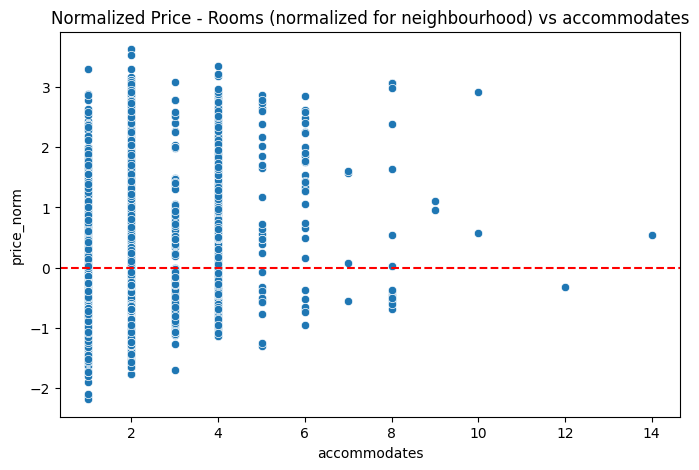

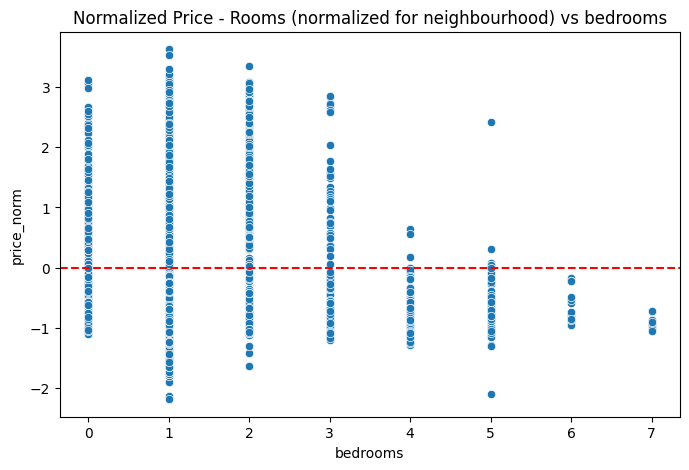

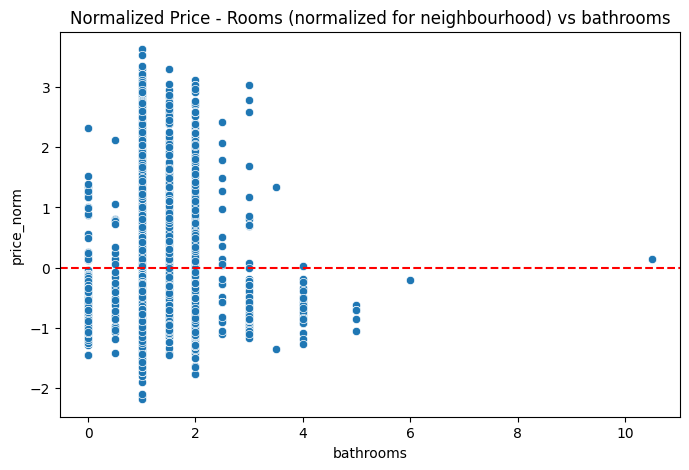

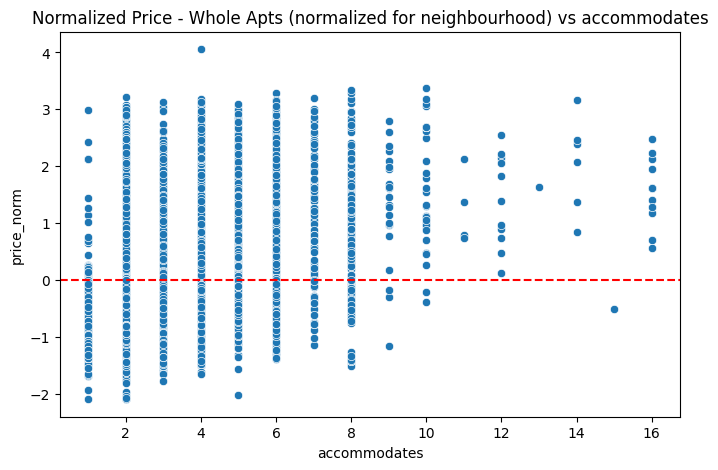

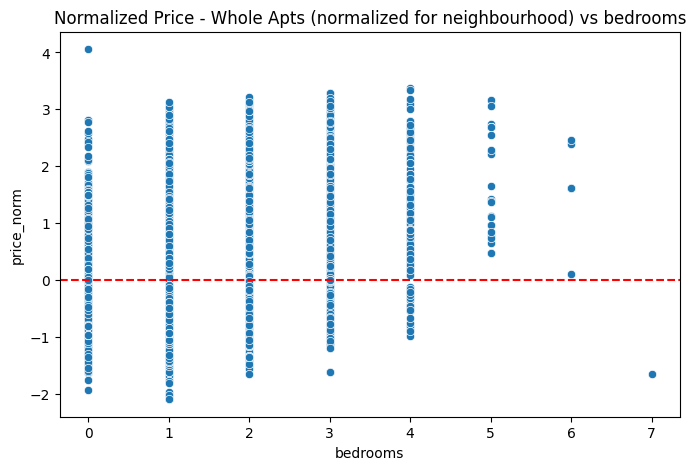

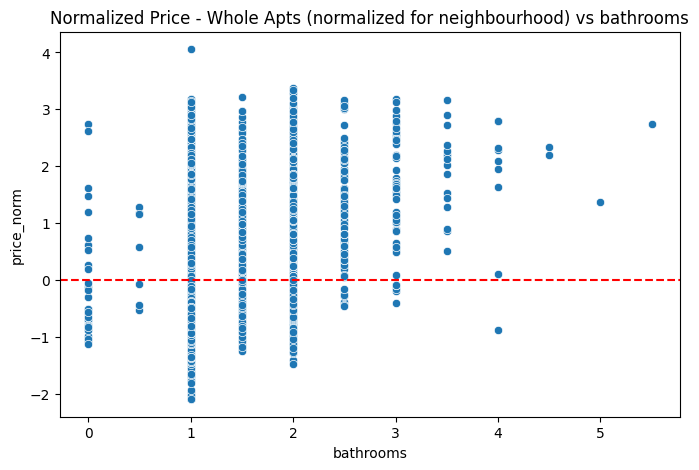

In [ ]:
# attempting to lessen the distortion of neighborhood on prices

df_room_filtered["price_norm"] = df_room_filtered.groupby("neighbourhood_cleansed")["price"].transform(
    lambda x: (x - x.mean()) / x.std()
)
df_apartment_filtered["price_norm"] = df_apartment_filtered.groupby("neighbourhood_cleansed")["price"].transform(
    lambda x: (x - x.mean()) / x.std()
)
features = ["accommodates", "bedrooms", "bathrooms"]

## PLOTTING NORMALIZED PRICE AGAINST 'accommodates', 'bedrooms' and 'bathrooms'
for col in features:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df_room_filtered, x=col, y="price_norm")
    plt.title(f"Normalized Price - Rooms (normalized for neighbourhood) vs {col}")
    plt.axhline(0, color="red", linestyle="--")
    plt.show()

for col in features:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df_apartment_filtered, x=col, y="price_norm")
    plt.title(f"Normalized Price - Whole Apts (normalized for neighbourhood) vs {col}")
    plt.axhline(0, color="red", linestyle="--")
    plt.show()

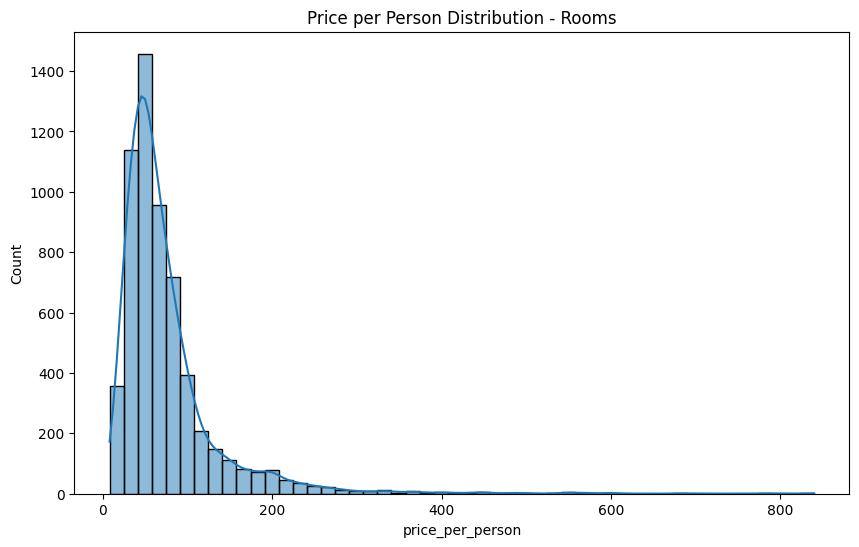

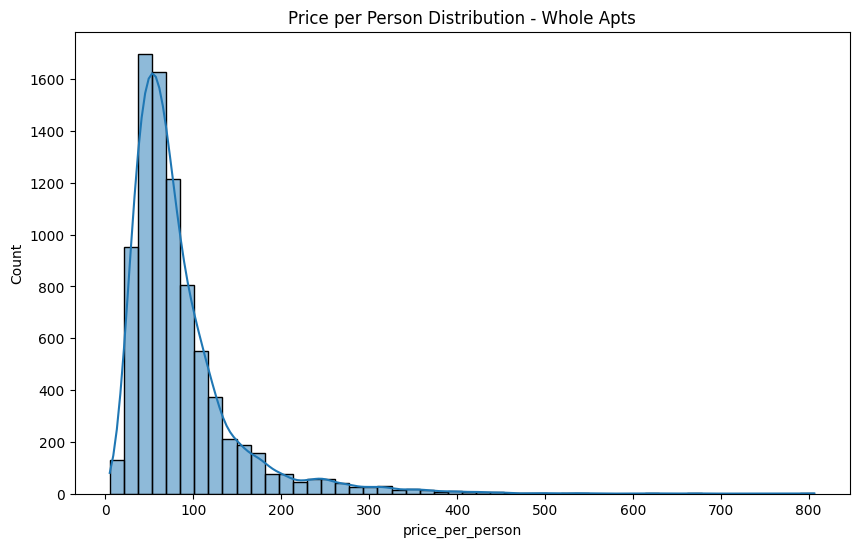

In [ ]:
# What does the distribution of price per person look like?

plt.figure(figsize=(10,6))
sns.histplot(df_room_filtered["price_per_person"], bins=50, kde=True)
plt.title("Price per Person Distribution - Rooms")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df_apartment_filtered["price_per_person"], bins=50, kde=True)
plt.title("Price per Person Distribution - Whole Apts")
plt.show()


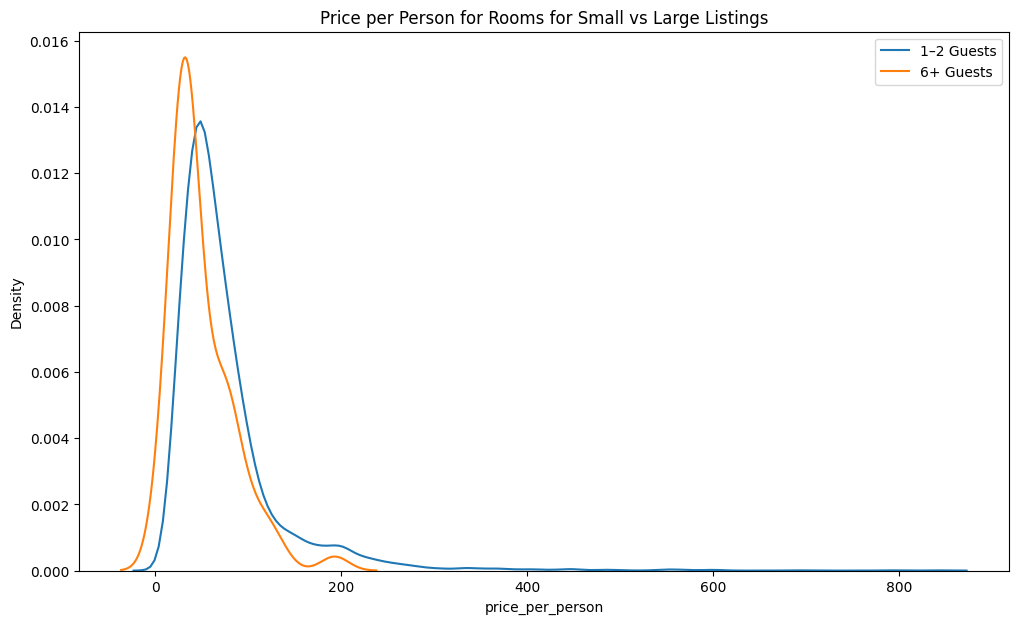

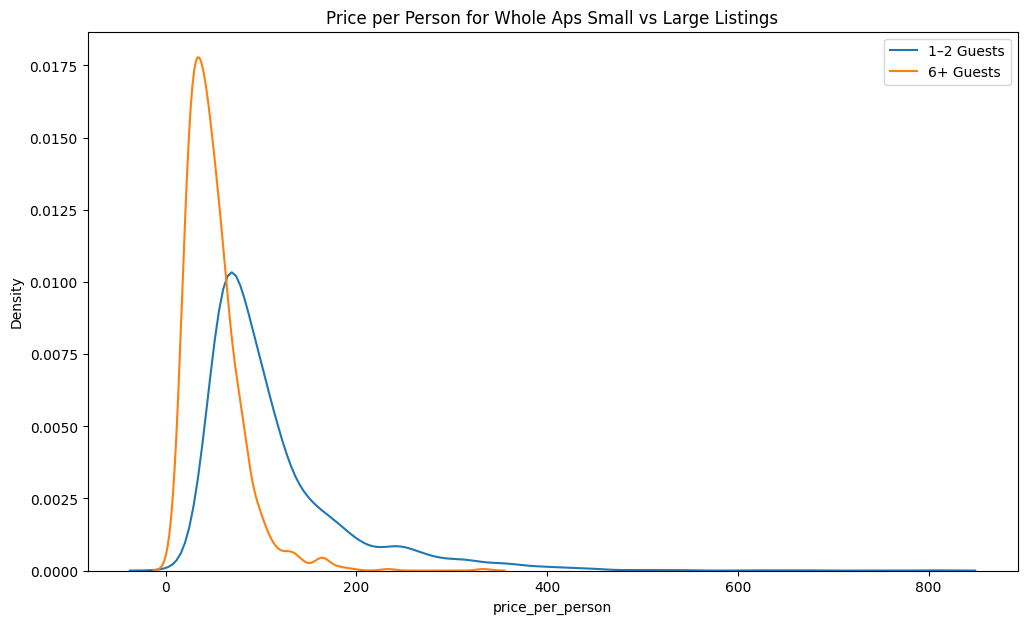

In [ ]:
# Let's try some overlays

plt.figure(figsize=(12,7))
sns.kdeplot(df_room_filtered[df_room_filtered["accommodates"] <= 2]["price_per_person"], label="1–2 Guests")
sns.kdeplot(df_room_filtered[df_room_filtered["accommodates"] >= 6]["price_per_person"], label="6+ Guests")

plt.title("Price per Person for Rooms for Small vs Large Listings")
plt.legend()
plt.show()

plt.figure(figsize=(12,7))
sns.kdeplot(df_apartment_filtered[df_apartment_filtered["accommodates"] <= 2]["price_per_person"], label="1–2 Guests")
sns.kdeplot(df_apartment_filtered[df_apartment_filtered["accommodates"] >= 6]["price_per_person"], label="6+ Guests")

plt.title("Price per Person for Whole Aps Small vs Large Listings")
plt.legend()
plt.show()

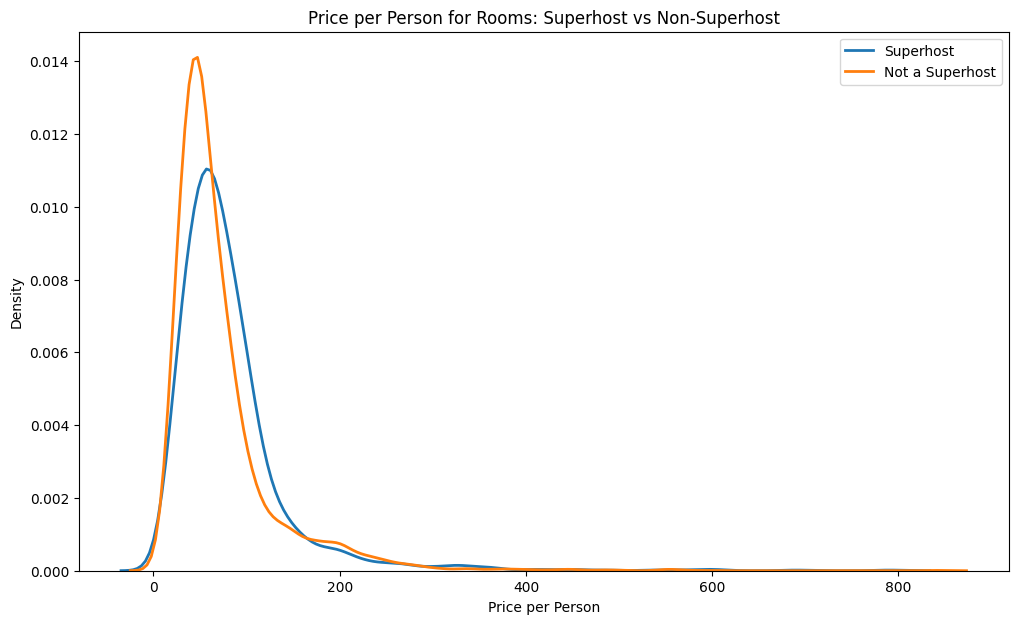

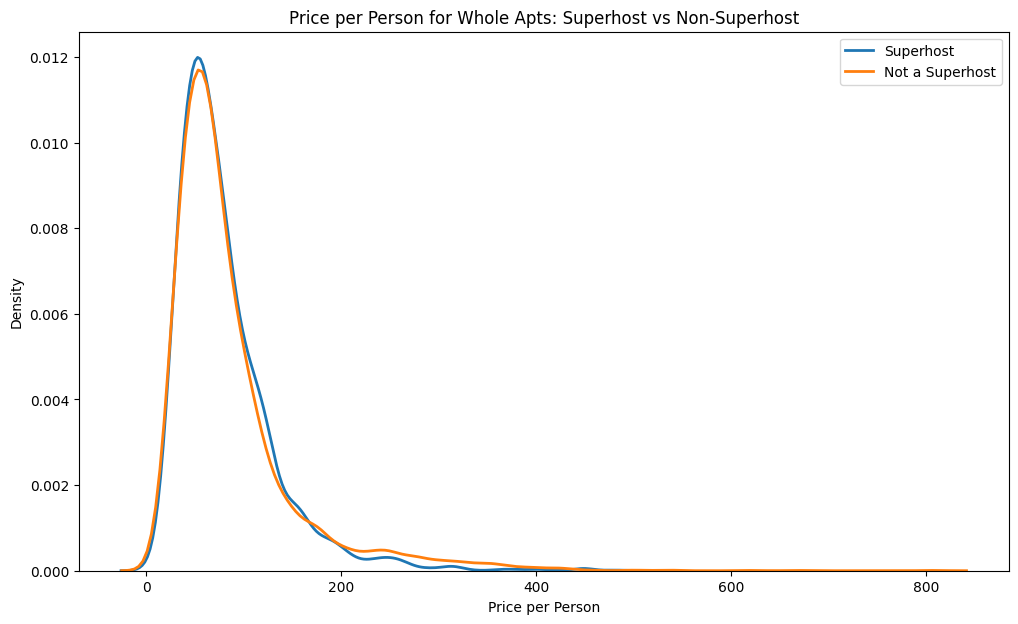

In [ ]:
# Let's look at the effect of Superhosts

plt.figure(figsize=(12,7))

# Superhost KDE
sns.kdeplot(
    df_room_filtered[df_room_filtered["host_is_superhost"] == 1]["price_per_person"],
    label="Superhost",
    linewidth=2
)

# Not a Superhost KDE
sns.kdeplot(
    df_room_filtered[df_room_filtered["host_is_superhost"] == 0]["price_per_person"],
    label="Not a Superhost",
    linewidth=2
)

plt.title("Price per Person for Rooms: Superhost vs Non-Superhost")
plt.xlabel("Price per Person")
plt.legend()
plt.show()

plt.figure(figsize=(12,7))

##########

# Superhost KDE
sns.kdeplot(
    df_apartment_filtered[df_apartment_filtered["host_is_superhost"] == 1]["price_per_person"],
    label="Superhost",
    linewidth=2
)

# Not a Superhost KDE
sns.kdeplot(
    df_apartment_filtered[df_apartment_filtered["host_is_superhost"] == 0]["price_per_person"],
    label="Not a Superhost",
    linewidth=2
)

plt.title("Price per Person for Whole Apts: Superhost vs Non-Superhost")
plt.xlabel("Price per Person")
plt.legend()
plt.show()

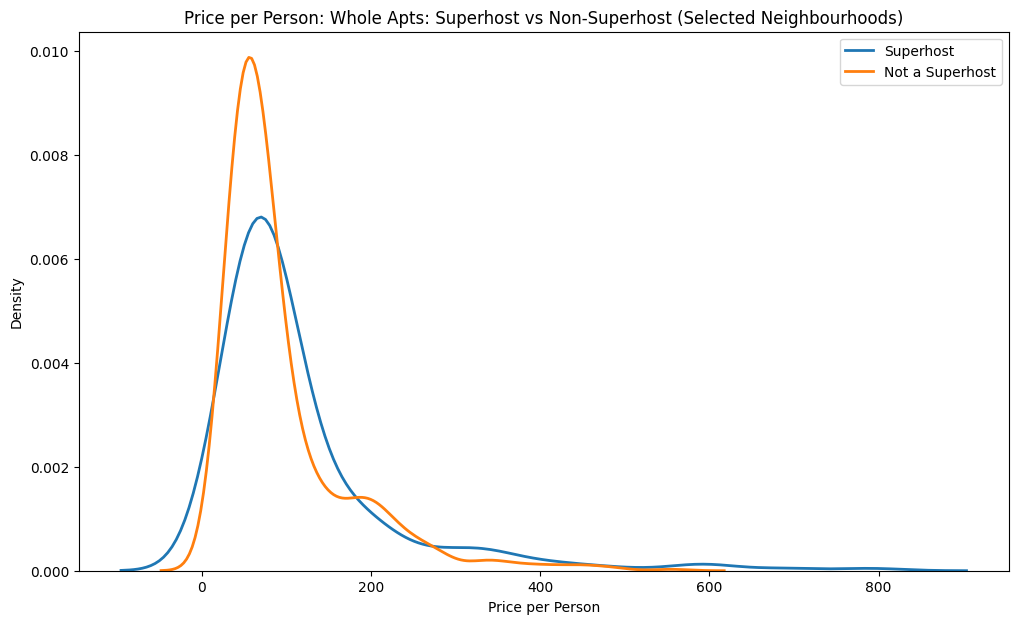

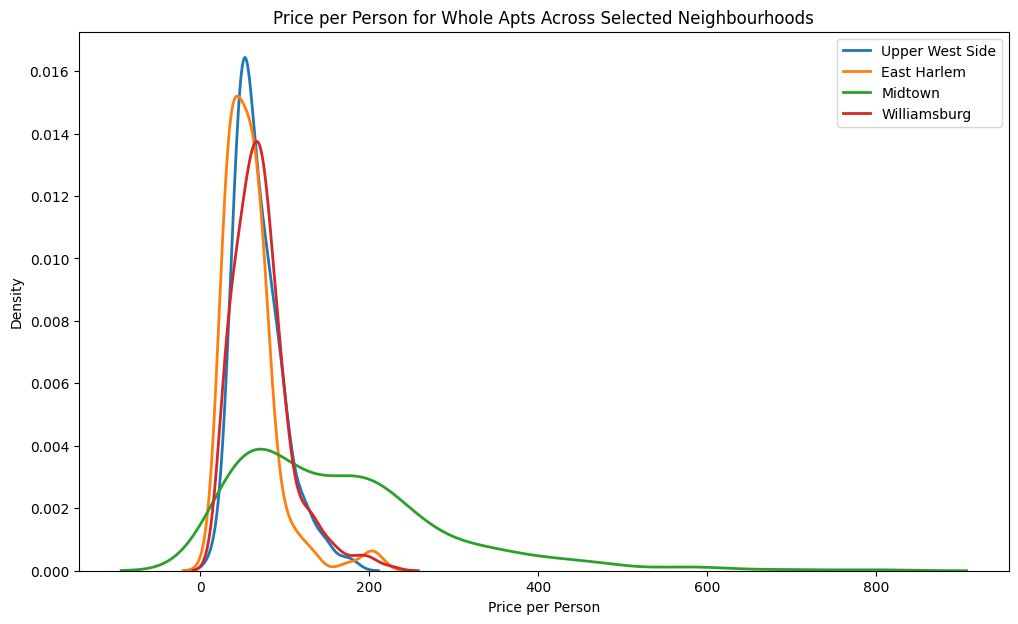

In [ ]:
#### Let's drill down for Whole Apartments price distribution for Superhosts vs Not-Superhosts - if we pick a few specific neighbourhoods, will this trend hold true?

selected_neighbourhoods = [
    "Upper West Side",
    "East Harlem",
    "Midtown",
    "Williamsburg"
]

df_nbh = df_room_filtered[
    df_room_filtered["neighbourhood_cleansed"].isin(selected_neighbourhoods)
]

plt.figure(figsize=(12,7))

sns.kdeplot(
    df_nbh[df_nbh["host_is_superhost"] == 1]["price_per_person"],
    label="Superhost",
    linewidth=2
)

sns.kdeplot(
    df_nbh[df_nbh["host_is_superhost"] == 0]["price_per_person"],
    label="Not a Superhost",
    linewidth=2
)

plt.title("Price per Person: Whole Apts: Superhost vs Non-Superhost (Selected Neighbourhoods)")
plt.xlabel("Price per Person")
plt.legend()
plt.show()

plt.figure(figsize=(12,7))

for nbh in selected_neighbourhoods:
    sns.kdeplot(
        df_room_filtered[df_room_filtered["neighbourhood_cleansed"] == nbh]["price_per_person"],
        label=nbh,
        linewidth=2
    )

plt.title("Price per Person for Whole Apts Across Selected Neighbourhoods")
plt.xlabel("Price per Person")
plt.legend()
plt.show()


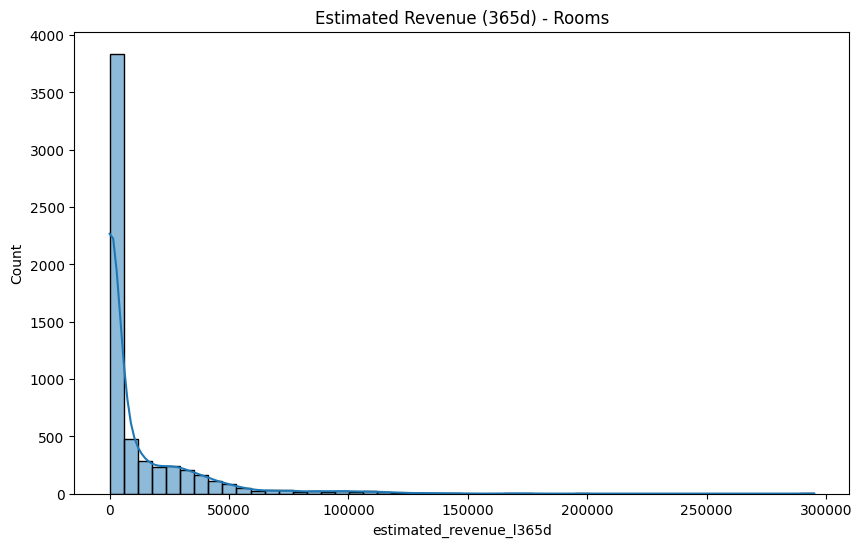

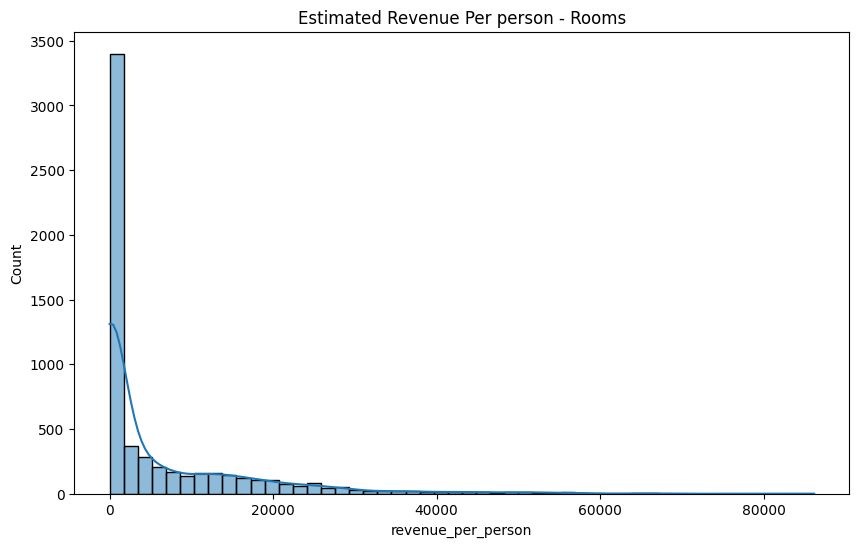

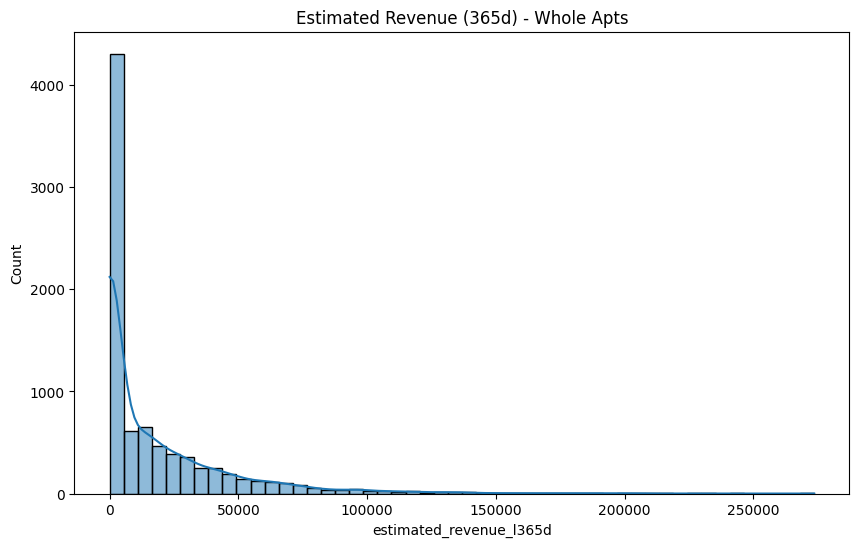

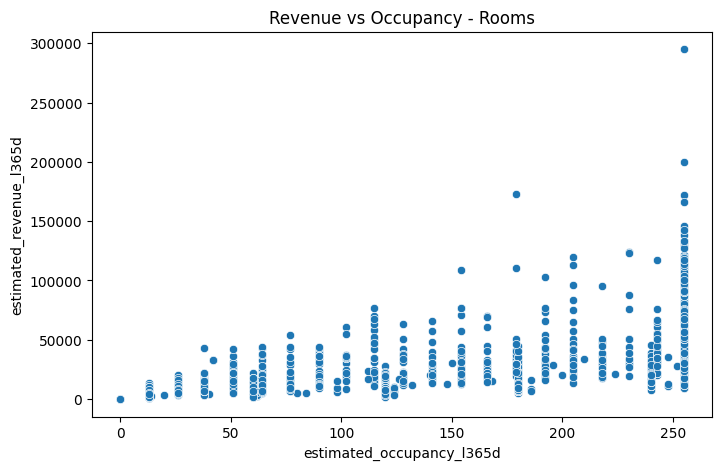

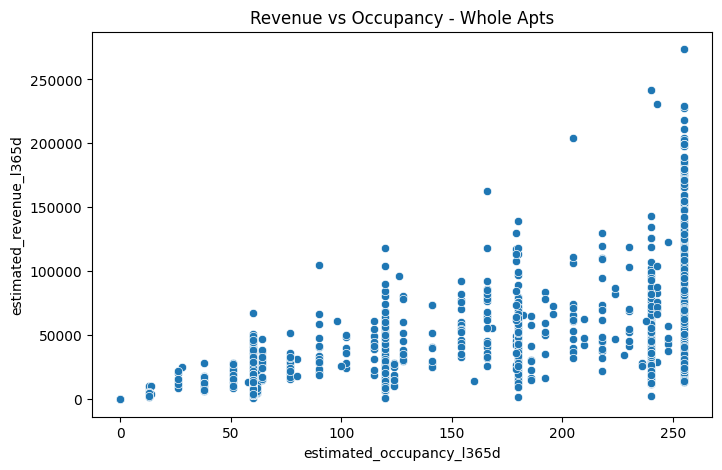

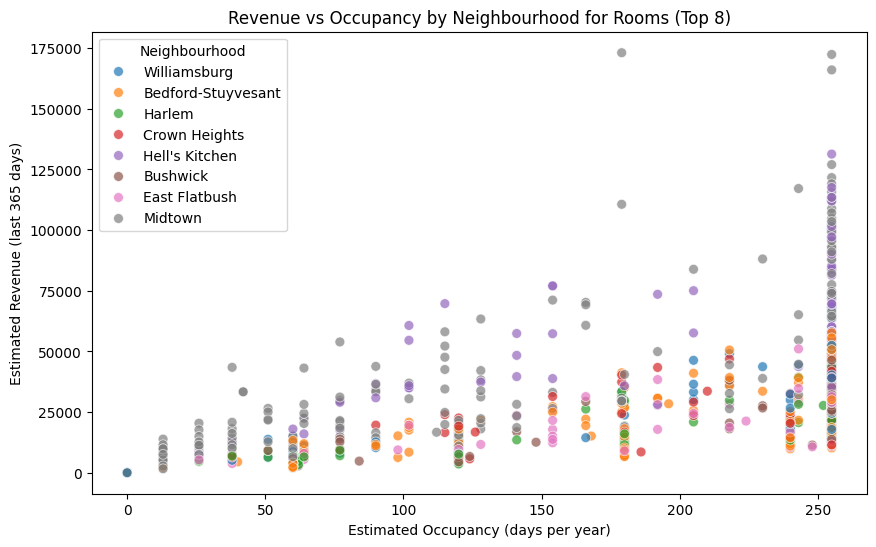

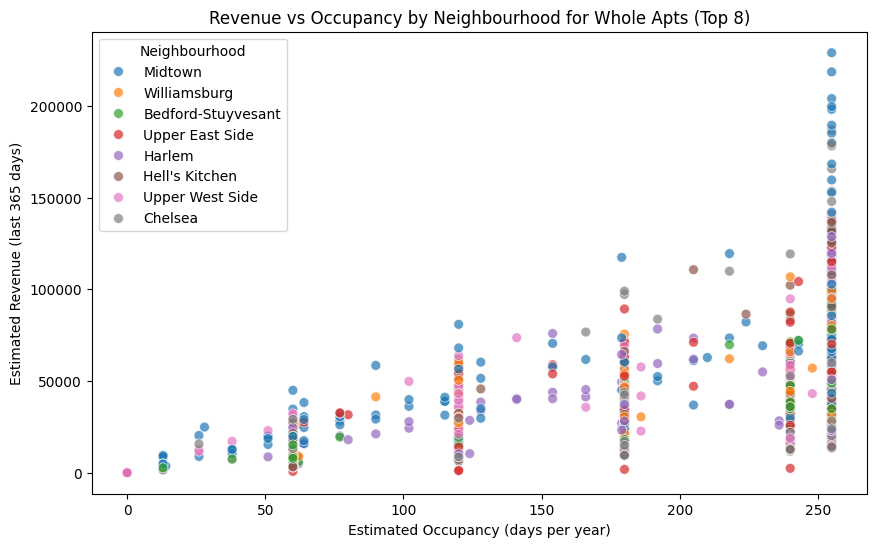

In [ ]:
# Let's look at revenue & occupancy relationships

plt.figure(figsize=(10,6))
sns.histplot(df_room_filtered["estimated_revenue_l365d"], bins=50, kde=True)
plt.title("Estimated Revenue (365d) - Rooms")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df_room_filtered["revenue_per_person"], bins=50, kde=True)
plt.title("Estimated Revenue Per person - Rooms")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df_apartment_filtered["estimated_revenue_l365d"], bins=50, kde=True)
plt.title("Estimated Revenue (365d) - Whole Apts")

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_room_filtered, x="estimated_occupancy_l365d", y="estimated_revenue_l365d")
plt.title("Revenue vs Occupancy - Rooms")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_apartment_filtered, x="estimated_occupancy_l365d", y="estimated_revenue_l365d")
plt.title("Revenue vs Occupancy - Whole Apts")
plt.show()

### Narrowing down revenue vs occupancy for the top few neighbourhoods

top_neighbourhoods = (
    df_room_filtered["neighbourhood_cleansed"]
    .value_counts()
    .head(8)
    .index
)

df_room_top = df_room_filtered[
    df_room_filtered["neighbourhood_cleansed"].isin(top_neighbourhoods)
]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_room_top,
    x="estimated_occupancy_l365d",
    y="estimated_revenue_l365d",
    hue="neighbourhood_cleansed",
    alpha=0.7,
    s=50
)

plt.title("Revenue vs Occupancy by Neighbourhood for Rooms (Top 8)")
plt.xlabel("Estimated Occupancy (days per year)")
plt.ylabel("Estimated Revenue (last 365 days)")
plt.legend(title="Neighbourhood")
plt.show()

top_neighbourhoods_apt = (
    df_apartment_filtered["neighbourhood_cleansed"]
    .value_counts()
    .head(8)
    .index
)

df_apt_top = df_apartment_filtered[
    df_apartment_filtered["neighbourhood_cleansed"].isin(top_neighbourhoods_apt)
]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_apt_top,
    x="estimated_occupancy_l365d",
    y="estimated_revenue_l365d",
    hue="neighbourhood_cleansed",
    alpha=0.7,
    s=50
)

plt.title("Revenue vs Occupancy by Neighbourhood for Whole Apts (Top 8)")
plt.xlabel("Estimated Occupancy (days per year)")
plt.ylabel("Estimated Revenue (last 365 days)")
plt.legend(title="Neighbourhood")
plt.show()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, ou

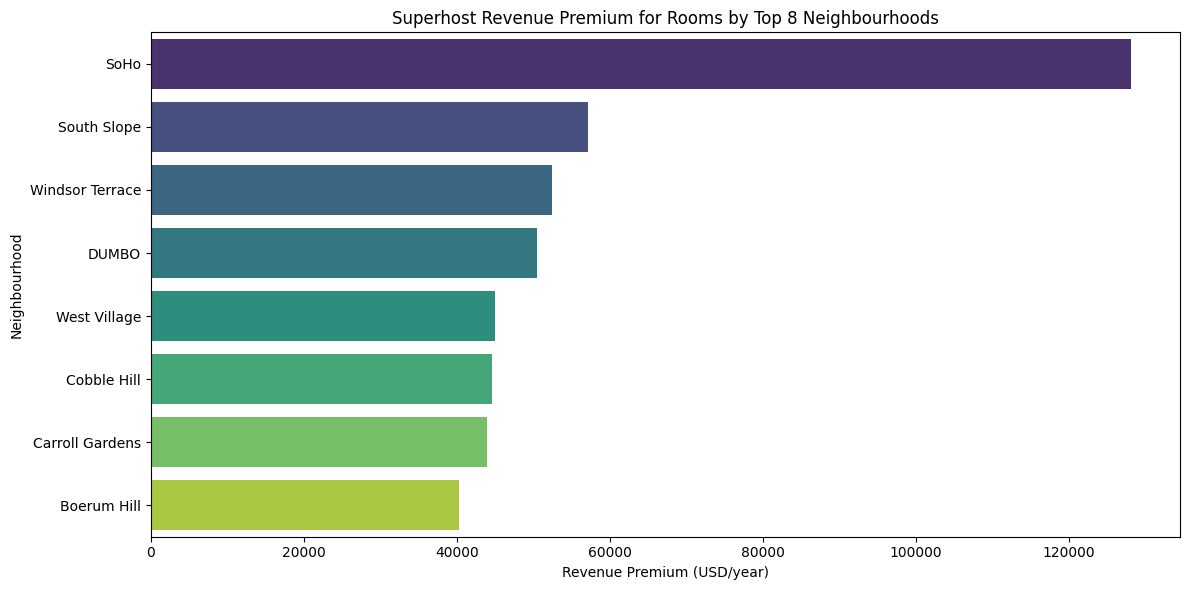

/tmp/ipython-input-1002333483.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


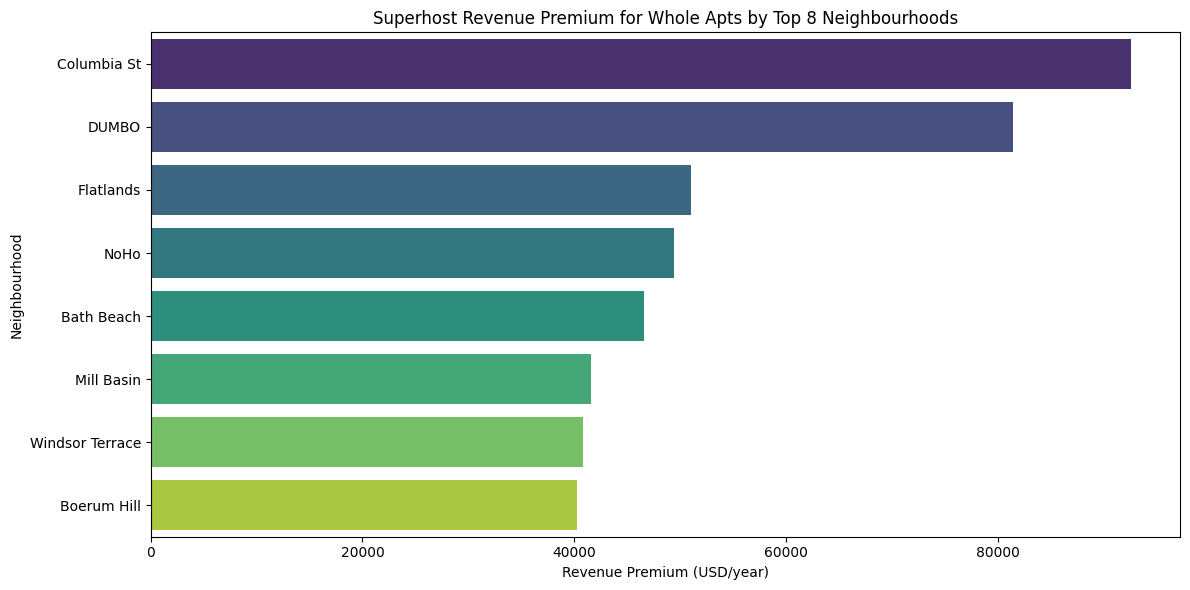

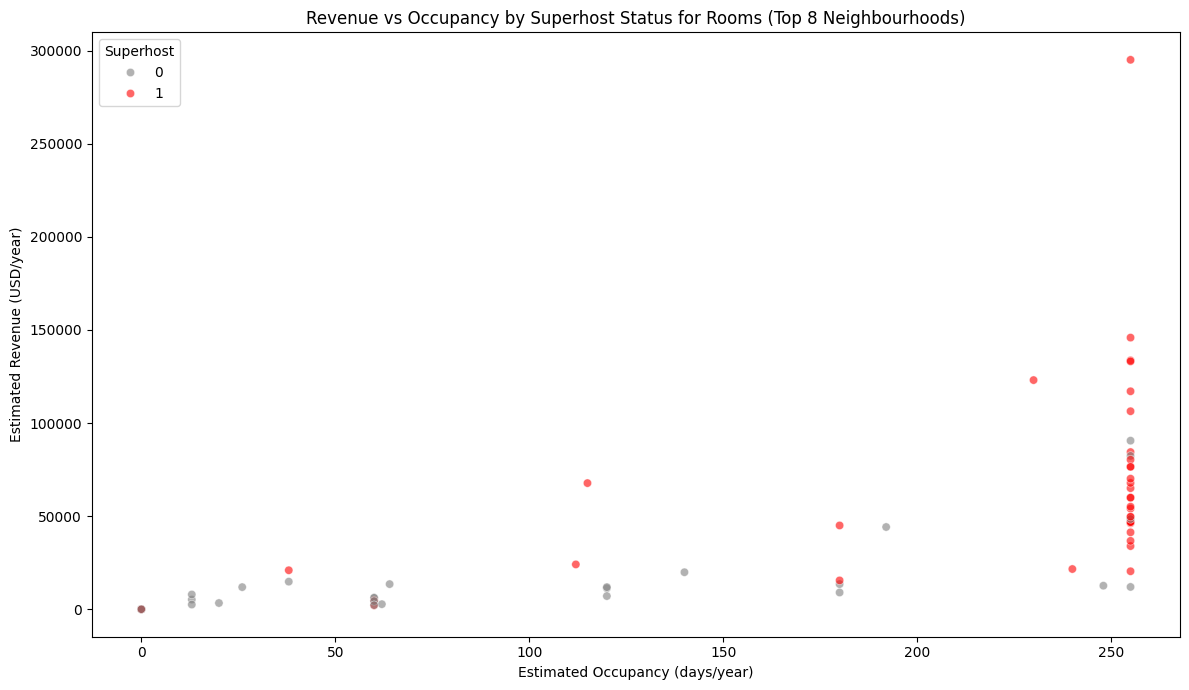

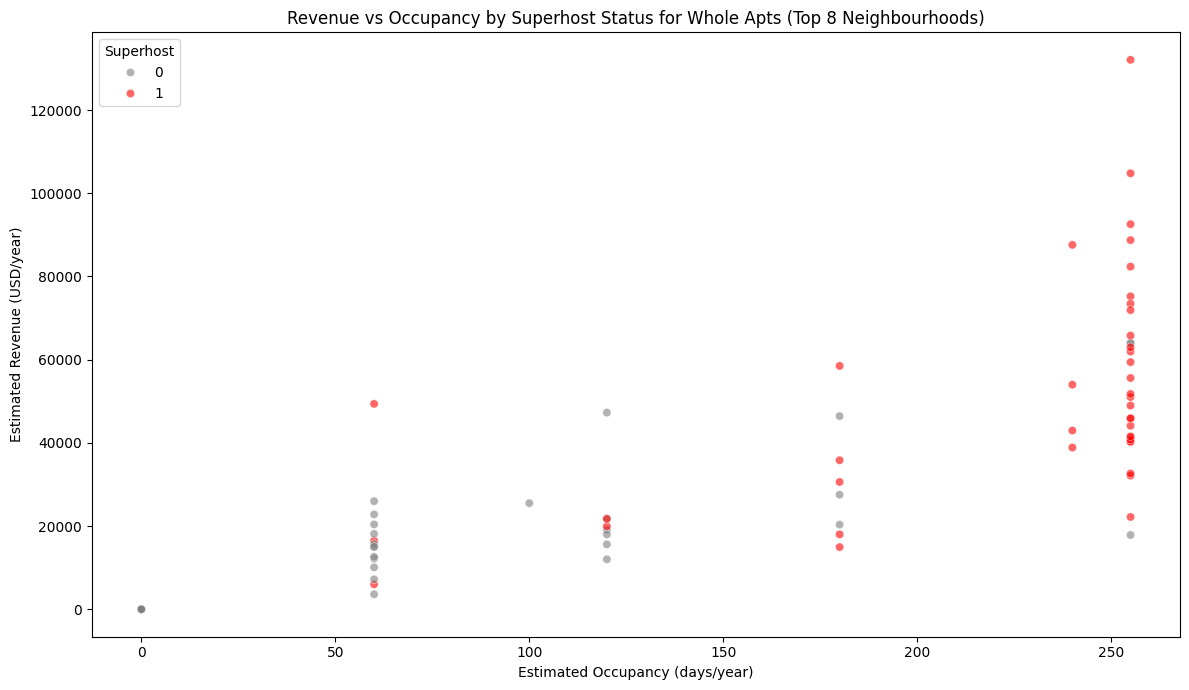

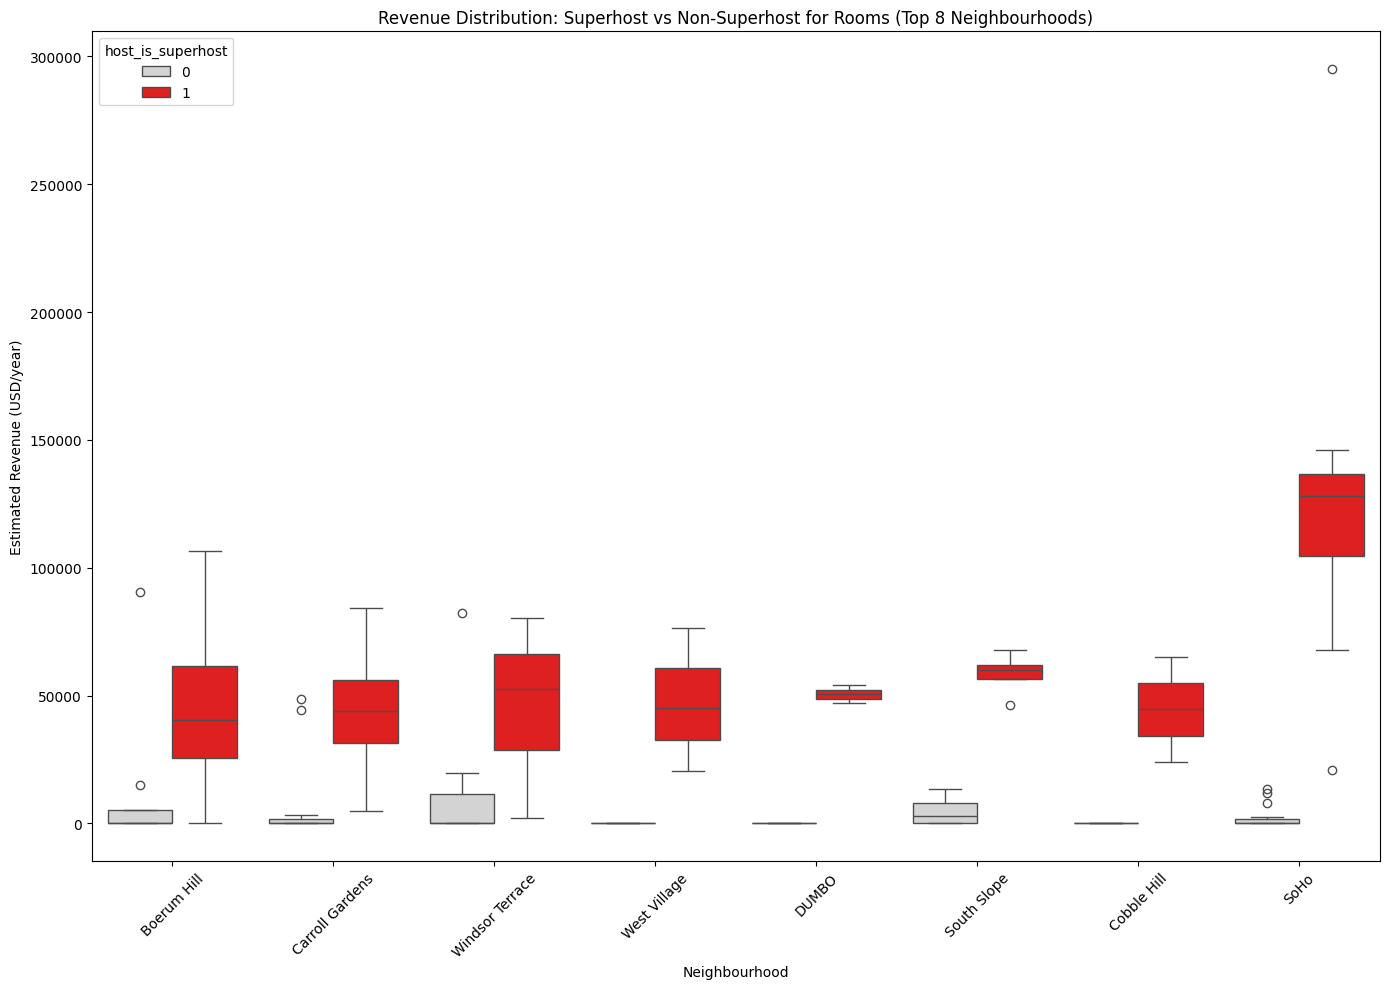

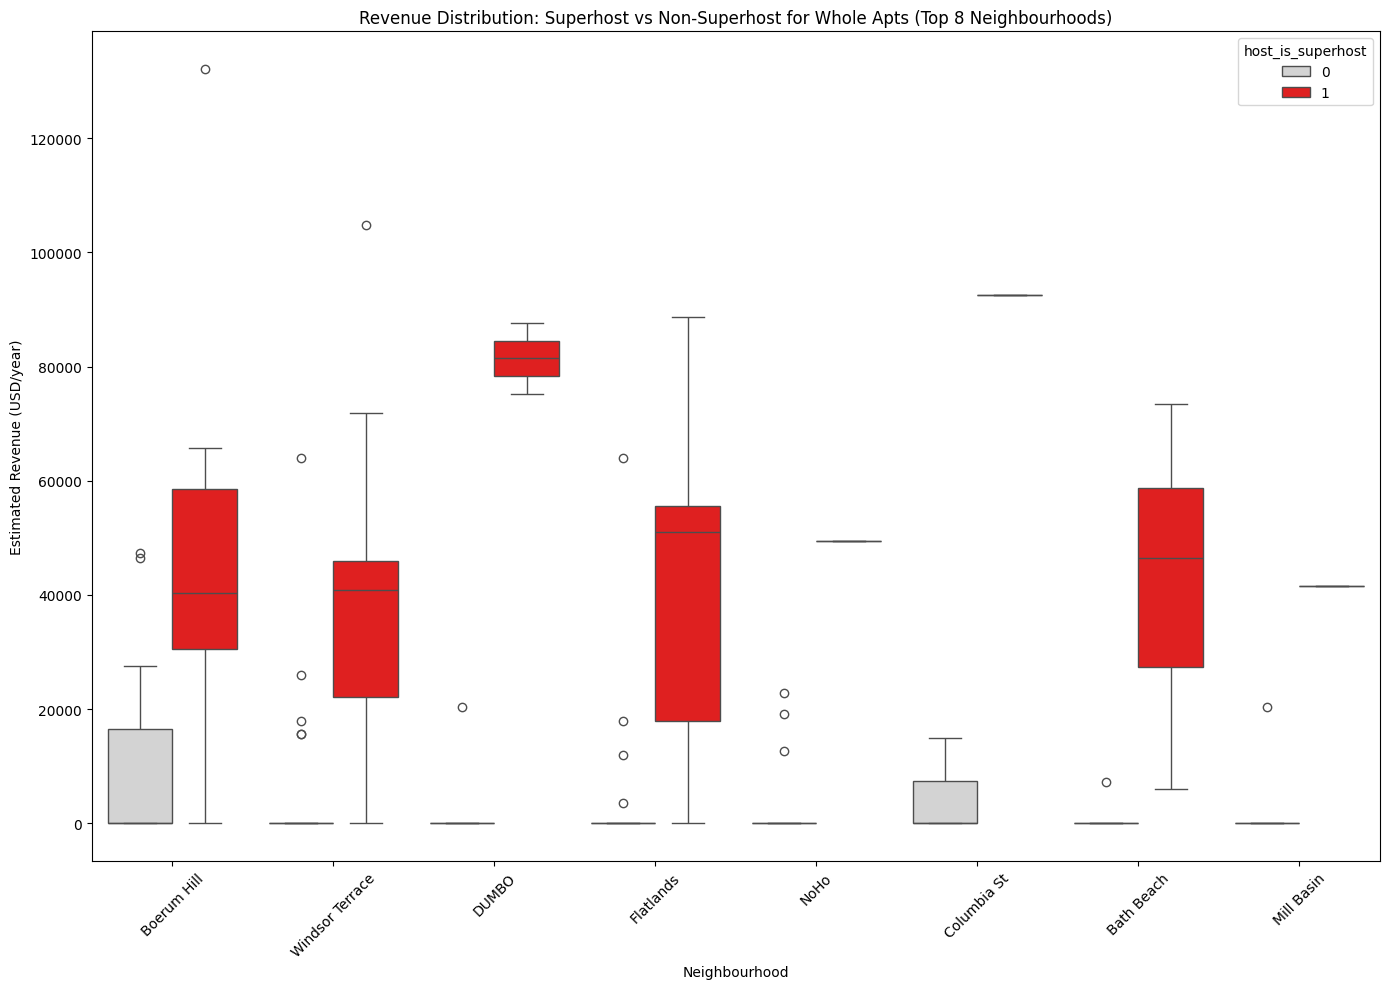

In [ ]:
# What is the impact of Superhosts within these locations? Where does being a Superhost matter the most?


# I'm calculating a "nightly_rate" just so that we can control for occupancy differences and detect a hypothesised pricing power premium of being a Superhost

df_room_filtered["nightly_rate"] = df_room_filtered["estimated_revenue_l365d"] / df_room_filtered["estimated_occupancy_l365d"].replace(0, pd.NA)
df_apartment_filtered["nightly_rate"] = df_apartment_filtered["estimated_revenue_l365d"] / df_apartment_filtered["estimated_occupancy_l365d"].replace(0, pd.NA)

### There were -1s in Superhost !!!!! Why?!?
df_room_filtered = df_room_filtered[df_room_filtered['host_is_superhost'].isin([0,1])]
df_apartment_filtered = df_apartment_filtered[df_apartment_filtered['host_is_superhost'].isin([0,1])]



grouped_room = (
    df_room_filtered.groupby(['neighbourhood_cleansed', 'host_is_superhost'])
    .agg(
        median_revenue=('estimated_revenue_l365d', 'median'),
        median_rate=('nightly_rate', 'median'),
        median_occupancy=('estimated_occupancy_l365d', 'median')
    )
    .reset_index()
)

grouped_apartment = (
    df_apartment_filtered.groupby(['neighbourhood_cleansed', 'host_is_superhost'])
    .agg(
        median_revenue=('estimated_revenue_l365d', 'median'),
        median_rate=('nightly_rate', 'median'),
        median_occupancy=('estimated_occupancy_l365d', 'median')
    )
    .reset_index()
)

#print(grouped_room.head(10))
#print(grouped_room.columns)
#print(grouped_room.duplicated(subset=['neighbourhood_cleansed', 'host_is_superhost']).sum())

pivot_room = grouped_room.pivot_table(
    index='neighbourhood_cleansed',
    columns='host_is_superhost',
    values=['median_revenue', 'median_rate', 'median_occupancy'],
    aggfunc='median'
)

pivot_room.columns = [
    f"{metric}_{'superhost' if sh == 1 else 'non_superhost'}"
    for metric, sh in pivot_room.columns
]
#pivot_room.head()

pivot_apartment = grouped_apartment.pivot_table(
    index='neighbourhood_cleansed',
    columns='host_is_superhost',
    values=['median_revenue', 'median_rate', 'median_occupancy'],
    aggfunc='median'
)

pivot_apartment.columns = [
    f"{metric}_{'superhost' if sh == 1 else 'non_superhost'}"
    for metric, sh in pivot_apartment.columns
]
#pivot_apartment.head()

## now what are the premiums for being a Superhost?

pivot_room["revenue_premium"] = pivot_room["median_revenue_superhost"] - pivot_room["median_revenue_non_superhost"]
pivot_room["rate_premium"] = pivot_room["median_rate_superhost"] - pivot_room["median_rate_non_superhost"]
pivot_room["occupancy_premium"] = pivot_room["median_occupancy_superhost"] - pivot_room["median_occupancy_non_superhost"]
#pivot_room.head(10)

pivot_apartment["revenue_premium"] = pivot_apartment["median_revenue_superhost"] - pivot_apartment["median_revenue_non_superhost"]
pivot_apartment["rate_premium"] = pivot_apartment["median_rate_superhost"] - pivot_apartment["median_rate_non_superhost"]
pivot_apartment["occupancy_premium"] = pivot_apartment["median_occupancy_superhost"] - pivot_apartment["median_occupancy_non_superhost"]
#pivot_apartment.head(10)

## picking top 8 neighbourhoods by revenue premium

top_neighbourhoods_room = pivot_room.sort_values("revenue_premium", ascending=False).head(8).index.tolist()
df_top_room = df_room_filtered[df_room_filtered["neighbourhood_cleansed"].isin(top_neighbourhoods_room)]
#df_top_room.head(10)
#print(top_neighbourhoods_room)

top_neighbourhoods_apt = pivot_apartment.sort_values("revenue_premium", ascending=False).head(8).index.tolist()
df_top_apt = df_apartment_filtered[df_apartment_filtered["neighbourhood_cleansed"].isin(top_neighbourhoods_apt)]
#df_top_apt.head(10)
#print(top_neighbourhoods_apt)

plt.figure(figsize=(12,6))
sns.barplot(
    data=pivot_room.loc[top_neighbourhoods_room].reset_index(),
    x="revenue_premium",
    y="neighbourhood_cleansed",
    palette="viridis"
)
plt.title("Superhost Revenue Premium for Rooms by Top 8 Neighbourhoods")
plt.xlabel("Revenue Premium (USD/year)")
plt.ylabel("Neighbourhood")
plt.tight_layout()
plt.show()

### Bar plots for revenue premium
plt.figure(figsize=(12,6))
sns.barplot(
    data=pivot_apartment.loc[top_neighbourhoods_apt].reset_index(),
    x="revenue_premium",
    y="neighbourhood_cleansed",
    palette="viridis"
)
plt.title("Superhost Revenue Premium for Whole Apts by Top 8 Neighbourhoods")
plt.xlabel("Revenue Premium (USD/year)")
plt.ylabel("Neighbourhood")
plt.tight_layout()
plt.show()


### Revenue vs occupancy for superhosts

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=df_top_room,
    x="estimated_occupancy_l365d",
    y="estimated_revenue_l365d",
    hue="host_is_superhost",
    alpha=0.6,
    palette={0:"gray", 1:"red"}
)
plt.title("Revenue vs Occupancy by Superhost Status for Rooms (Top 8 Neighbourhoods)")
plt.xlabel("Estimated Occupancy (days/year)")
plt.ylabel("Estimated Revenue (USD/year)")
plt.legend(title="Superhost")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=df_top_apt,
    x="estimated_occupancy_l365d",
    y="estimated_revenue_l365d",
    hue="host_is_superhost",
    alpha=0.6,
    palette={0:"gray", 1:"red"}
)
plt.title("Revenue vs Occupancy by Superhost Status for Whole Apts (Top 8 Neighbourhoods)")
plt.xlabel("Estimated Occupancy (days/year)")
plt.ylabel("Estimated Revenue (USD/year)")
plt.legend(title="Superhost")
plt.tight_layout()
plt.show()

### Plotting Revenue by neighbourhood and superhost

plt.figure(figsize=(14,10))
sns.boxplot(
    data=df_top_room,
    x="neighbourhood_cleansed",
    y="estimated_revenue_l365d",
    hue="host_is_superhost",
    palette={0:"lightgray", 1:"red"}
)
plt.title("Revenue Distribution: Superhost vs Non-Superhost for Rooms (Top 8 Neighbourhoods)")
plt.xlabel("Neighbourhood")
plt.ylabel("Estimated Revenue (USD/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,10))
sns.boxplot(
    data=df_top_apt,
    x="neighbourhood_cleansed",
    y="estimated_revenue_l365d",
    hue="host_is_superhost",
    palette={0:"lightgray", 1:"red"}
)
plt.title("Revenue Distribution: Superhost vs Non-Superhost for Whole Apts (Top 8 Neighbourhoods)")
plt.xlabel("Neighbourhood")
plt.ylabel("Estimated Revenue (USD/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Hypothesis: more expensive neighbourhoods would have larger apartments converted to more smaller ones in order to maximize
#  revenue generated from Airbnb. Is this so?